In [ ]:
!pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.5 MB 10.0 MB/s eta 0:00:01
   -------------- ------------------------- 4.2/11.5 MB 10.5 MB/s eta 0:00:01
   --------------------- ------------------ 6.3/11.5 MB 10.2 MB/s eta 0:00:01
   ----------------------------- ---------- 8.4/11.5 MB 10.2 MB/s eta 0:00:01
   ----------------------------------- ---- 10.2/11.5 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 10.0 MB/s eta 0:00:00


In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# Lectura de datos

In [ ]:
efective_experiments = [36]
drain_current = list()
pwm_list = list()
time_pwm = list()
ds_voltage = list()
ds_transient_voltage = list()
ds_transient_current = list()
time_open = list()
temperature = list()
time = list()
init = True

for experiment in efective_experiments:
    # Cargar el archivo .mat
    mat_data = scipy.io.loadmat(f'../MOSFET_Thermal_Overstress_Aging_v0/Test_{experiment}_run_1.mat', squeeze_me=True, struct_as_record=False)

    # Acceder al struct 'measurement'
    measurement = mat_data['measurement']

    # Liste de tuplas que incluye el tiempo donde gateState == 1. Estas tuplas van de (tiempo apertura, tiepo cierre) y el tiempo de cierre es el siguiente momento donde gateState == 0.
    # Si el experimento termina en gateState == 1, el tiempo de cierre es infinito.

    pwm = measurement.pwmTempControllerState
    init = True
    for i in range(len(pwm)):
        if init:
            t_init_pwm = datetime.strptime(pwm[i].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            init = False
        time_pwm.append(datetime.strptime(pwm[i].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()-t_init_pwm)
        pwm_list.append(pwm[i].gateState)
        
        if pwm[i].gateState == 1:
            t_open = datetime.strptime(pwm[i].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            try:
                t_close = datetime.strptime(pwm[i+1].time, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            except IndexError:
                t_close = float('inf')

            time_open.append((t_open,t_close))
        
    print(f"Tiempo abierto: {time_open}")


    # Acceder al campo 'steady'
    steady = measurement.steadyState 


    
    for measure in steady:
        
        fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
        time.append(fecha_dt)

        # Leer corriente del drain 
        drain_current_n = measure.timeDomain.drainCurrent
        drain_current.append(drain_current_n)

        # Leer voltaje drain-source

        ds_voltage_n = measure.timeDomain.drainSourceVoltage
        ds_voltage.append(ds_voltage_n)
        temperature_n = measure.timeDomain.flangeTemperature
        temperature.append(temperature_n)
    # Aqui hago dataframe de pandas para filtrar los datos.
    # Filtro solo la corriente y voltajes que se encuentran en los intervalos de tiempo donde gateState == 1.


        # Leer Temperatura
    df = pd.DataFrame({'time': time, 'drain_current': drain_current, 'ds_voltage': ds_voltage , 'temperature': temperature})
    #df['time'] = pd.to_datetime(df['time'], unit='s')
    #dfs = [df[(df["time"] >= start) & (df["time"] <= end)] for start, end in time_open]
    #filtered_df = pd.concat(dfs).sort_index()
    filtered_df = df

    
    print(len(time))
    print(len(drain_current))
    print(len(ds_voltage))

Tiempo abierto: [(1282342938.978, 1282342942.578), (1282342943.009, 1282342947.008), (1282342947.435, 1282342952.635), (1282342953.06, 1282342959.86), (1282342960.29, 1282342968.17), (1282342968.598, 1282342977.398), (1282342977.827, 1282342987.426), (1282342987.853, 1282342997.453), (1282342997.889, 1282343003.794), (1282343008.718, 1282343009.918), (1282343010.749, 1282343012.349), (1282343013.578, 1282343015.977), (1282343016.81, 1282343018.81), (1282343019.636, 1282343022.036), (1282343022.867, 1282343025.267), (1282343026.096, 1282343028.896), (1282343029.725, 1282343032.925), (1282343033.766, 1282343036.983), (1282343037.812, 1282343041.012), (1282343041.841, 1282343045.441), (1282343046.272, 1282343049.872), (1282343050.701, 1282343054.301), (1282343055.129, 1282343058.729), (1282343059.561, 1282343063.561), (1282343064.389, 1282343067.989), (1282343068.416, 1282343068.482), (1282343073.319, 1282343074.52), (1282343075.747, 1282343076.947), (1282343078.175, 1282343079.775), (128

# Graficos

Normalización de la resistencia y se cambia la escala de tiempo para que parta en 0.

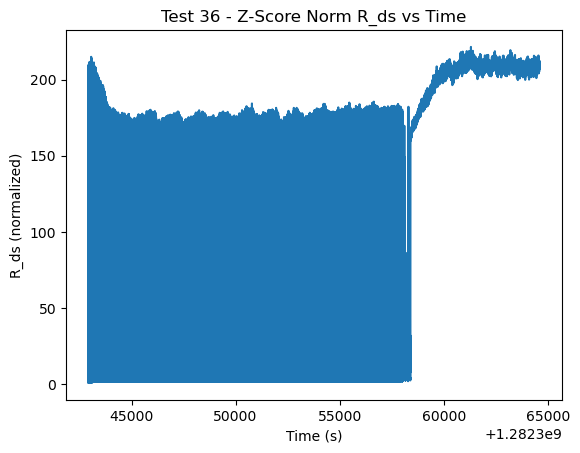

In [ ]:
filtered_df["R_ds"] = filtered_df["ds_voltage"] / filtered_df["drain_current"]
R_mean = filtered_df["R_ds"].mean()
R_std = filtered_df["R_ds"].std()
time_init = filtered_df["time"].iloc[0]
# Aqui se cambia la referencia del tiempo para que parta en 0.
# Normalizo la resistencia según lo que encontré en google, pero debe estar malo.

#filtered_df["time"] = filtered_df["time"].apply(lambda x: (x - time_init)/60)
#filtered_df["R_ds"] = filtered_df["R_ds"].apply(lambda x: (x - R_mean)/R_std)
#R_init = filtered_df["R_ds"].iloc[0]
#filtered_df["R_ds"] = filtered_df["R_ds"].apply(lambda x: (x - R_init))

plt.plot(filtered_df["time"], filtered_df["R_ds"])


# Apply gaussian filter to the data
from scipy.ndimage import gaussian_filter1d

#filtered_df["R_ds"] = gaussian_filter1d(filtered_df["R_ds"], sigma=100)
#plt.plot(filtered_df["time"], filtered_df["R_ds"])
plt.xlabel("Time (s)")
plt.ylabel("R_ds (normalized)")

plt.title(f"Test {experiment} - Z-Score Norm R_ds vs Time")
plt.show()

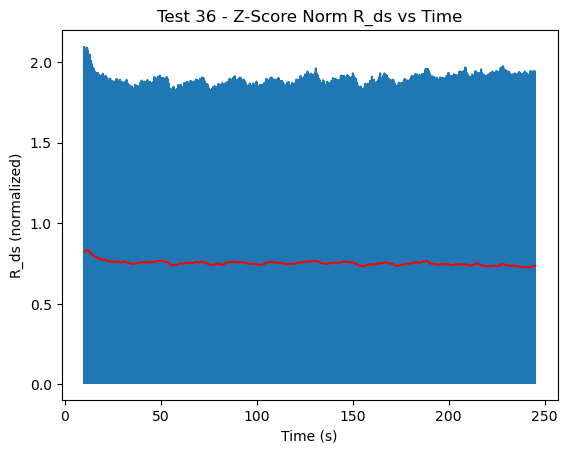

In [ ]:
df2 = filtered_df[(filtered_df["time"] >= 10) & (filtered_df["time"] <= 245)]
plt.xlabel("Time (s)")
plt.ylabel("R_ds (normalized)")

plt.title(f"Test {experiment} - Z-Score Norm R_ds vs Time")

plt.plot(df2["time"], df2["R_ds"])
plt.plot(df2["time"], gaussian_filter1d(df2["R_ds"], sigma=100), color='red', label='Rolling Mean')

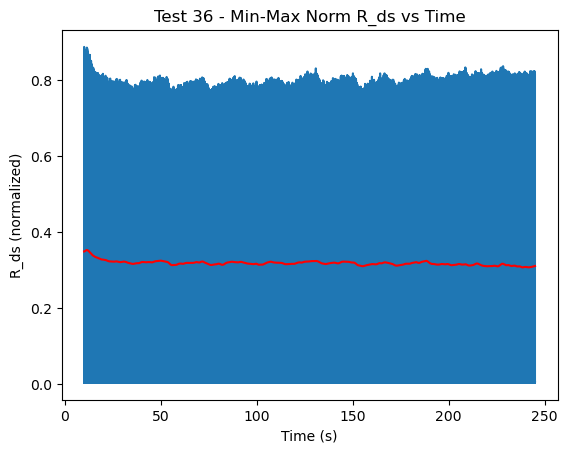

In [ ]:
filtered_df["R_ds"] = filtered_df["ds_voltage"] / filtered_df["drain_current"]

time_init = filtered_df["time"].iloc[0]
# Aqui se cambia la referencia del tiempo para que parta en 0.
# Normalizo la resistencia según lo que encontré en google, pero debe estar malo.
filtered_df["time"] = filtered_df["time"].apply(lambda x: (x - time_init)/60)

R_min = filtered_df["R_ds"].min()
R_max = filtered_df["R_ds"].max()
filtered_df["norm2_R_ds"] = filtered_df["R_ds"].apply(lambda x:  (x - R_min)/(R_max - R_min))
R_init = filtered_df["norm2_R_ds"].iloc[0]
filtered_df["norm2_R_ds"] = filtered_df["norm2_R_ds"].apply(lambda x:  (x - R_init))

df2 = filtered_df[(filtered_df["time"] >= 10) & (filtered_df["time"] <= 245)]
plt.xlabel("Time (s)")
plt.ylabel("R_ds (normalized)")

plt.title(f"Test {experiment} - Min-Max Norm R_ds vs Time")

plt.plot(df2["time"], df2["norm2_R_ds"])
plt.plot(df2["time"], gaussian_filter1d(df2["norm2_R_ds"], sigma=100), color='red', label='Rolling Mean')

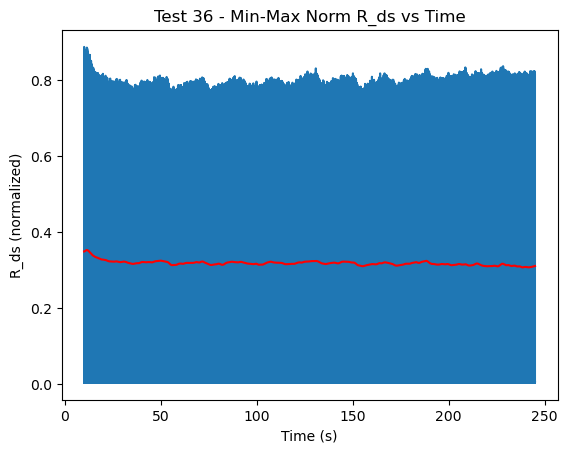

In [ ]:
plt.xlabel("Time (s)")
plt.ylabel("R_ds (normalized)")

plt.title(f"Test {experiment} - Min-Max Norm R_ds vs Time")

plt.plot(df2["time"], df2["norm2_R_ds"])
plt.plot(df2["time"], gaussian_filter1d(df2["norm2_R_ds"], sigma=100), color='red', label='Rolling Mean')

# Good shi

Text(0.5, 1.0, 'Test 36 - Drain Current vs Time')

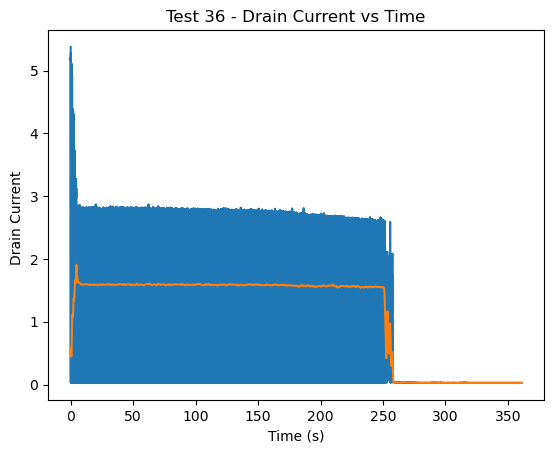

In [ ]:

plt.plot(filtered_df["time"], filtered_df["drain_current"])

plt.plot(filtered_df["time"], gaussian_filter1d(filtered_df["drain_current"], sigma=50))
plt.xlabel("Time (s)")
plt.ylabel("Drain Current ")
plt.title(f"Test {experiment} - Drain Current vs Time")

In [ ]:

filtered_on_df = filtered_df[(filtered_df["drain_current"] > 2)]


In [ ]:
filtered_on_df["R_ds"] = filtered_on_df["ds_voltage"] / filtered_on_df["drain_current"]
time_init = filtered_on_df["time"].iloc[0]
filtered_on_df["time"] = filtered_on_df["time"].apply(lambda x: (x - time_init)/60)


C:\Users\Pato\AppData\Local\Temp\ipykernel_34604\2411906783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_on_df["R_ds"] = filtered_on_df["ds_voltage"] / filtered_on_df["drain_current"]
C:\Users\Pato\AppData\Local\Temp\ipykernel_34604\2411906783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_on_df["time"] = filtered_on_df["time"].apply(lambda x: (x - time_init)/60)


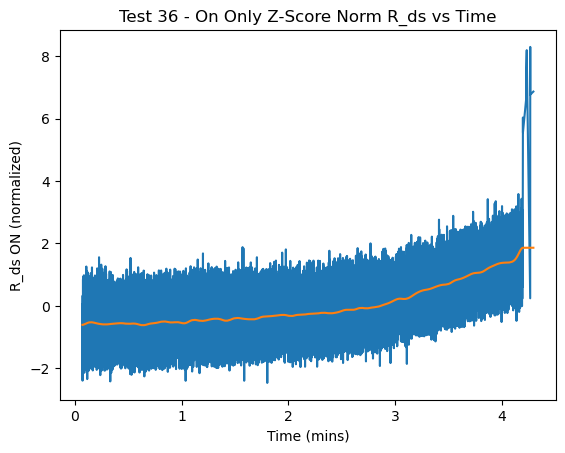

In [ ]:

#filtered_on_df = filtered_on_df[filtered_on_df["time"] < 230]
#filtered_on_df = filtered_on_df[filtered_on_df["drain_current"]< 2.9]  
R_init = filtered_on_df["R_ds"].iloc[0]
R_mean = filtered_on_df["R_ds"].mean()
R_std = filtered_on_df["R_ds"].std()
filtered_on_df["norm_R_ds"] = filtered_on_df["R_ds"].apply(lambda x:  (x - R_mean)/R_std)

plt.plot(filtered_on_df["time"], filtered_on_df["norm_R_ds"])
plt.plot(filtered_on_df["time"],gaussian_filter1d(filtered_on_df["norm_R_ds"], sigma=200))
plt.xlabel("Time (mins)")
plt.ylabel("R_ds ON (normalized)")
plt.title(f"Test {experiment} - On Only Z-Score Norm R_ds vs Time")
plt.show()

C:\Users\Pato\AppData\Local\Temp\ipykernel_34604\1276795961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_on_df["norm2_R_ds"] = filtered_on_df["R_ds"].apply(lambda x:  (x - R_min)/(R_max - R_min))
C:\Users\Pato\AppData\Local\Temp\ipykernel_34604\1276795961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_on_df["norm2_R_ds"] = filtered_on_df["norm2_R_ds"].apply(lambda x:  (x - R_init))


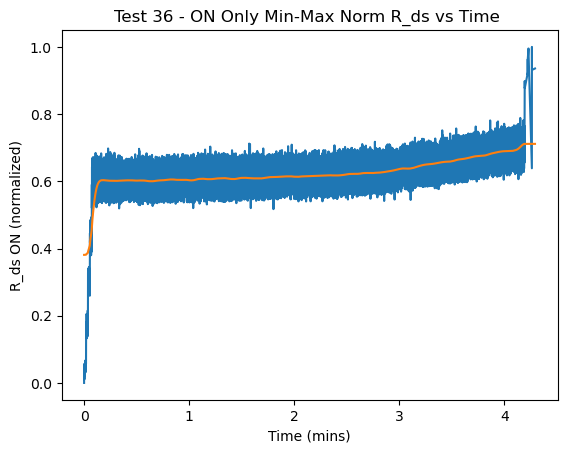

In [ ]:
#min-max normalization
R_min = filtered_on_df["R_ds"].min()
R_max = filtered_on_df["R_ds"].max()
filtered_on_df["norm2_R_ds"] = filtered_on_df["R_ds"].apply(lambda x:  (x - R_min)/(R_max - R_min))
R_init = filtered_on_df["norm2_R_ds"].iloc[0]
filtered_on_df["norm2_R_ds"] = filtered_on_df["norm2_R_ds"].apply(lambda x:  (x - R_init))
plt.plot(filtered_on_df["time"], filtered_on_df["norm2_R_ds"])
plt.plot(filtered_on_df["time"],gaussian_filter1d(filtered_on_df["norm2_R_ds"], sigma=200))

plt.xlabel("Time (mins)")
plt.ylabel("R_ds ON (normalized)")
plt.title(f"Test {experiment} - ON Only Min-Max Norm R_ds vs Time ")
plt.show()


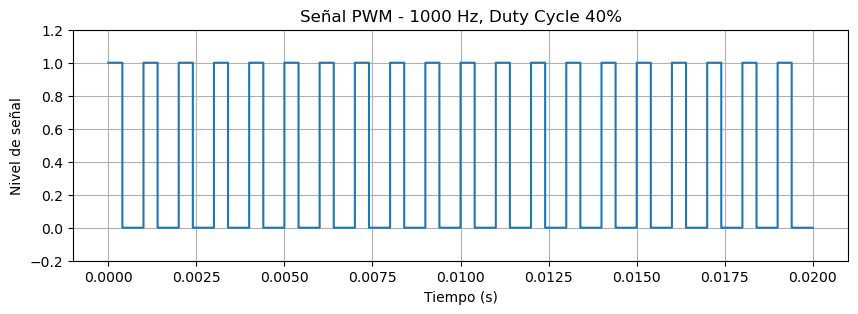

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros PWM
frecuencia = 1000  # Hz
duty_cycle = 40    # Porcentaje
duracion = 2e-2    # Duración total de la señal (2 ms para ver dos periodos)

# Cálculos
periodo = 1 / frecuencia                      # Periodo de la señal en segundos
paso_tiempo = 1e-6                            # Paso temporal de 1 µs para mayor resolución
t = np.arange(0, duracion, paso_tiempo)      # Vector de tiempo
pwm = ((t % periodo) < (duty_cycle / 100) * periodo).astype(float)  # Señal PWM

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(t , pwm, drawstyle='steps-post')

plt.title(f'Señal PWM - {frecuencia} Hz, Duty Cycle {duty_cycle}%')
plt.xlabel('Tiempo (s)')
plt.ylabel('Nivel de señal')
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()

Text(0, 0.5, 'Nivel de señal')

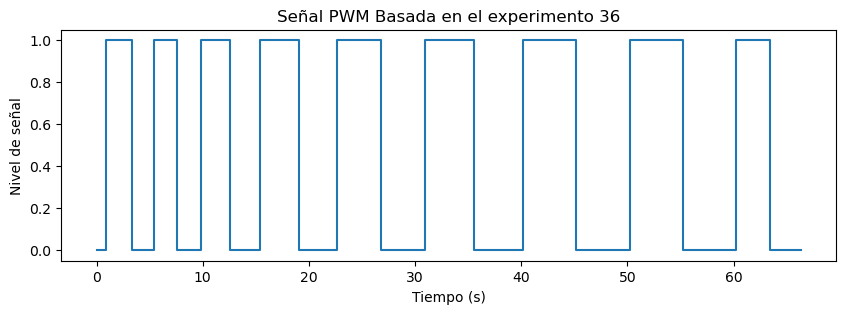

In [ ]:
plt.figure(figsize=(10, 3))

plt.plot(time_pwm[:20], pwm_list[:20], drawstyle='steps-mid')
plt.title(f'Señal PWM Basada en el experimento {experiment}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Nivel de señal')

Text(0, 0.5, 'R_ds (normalized)')

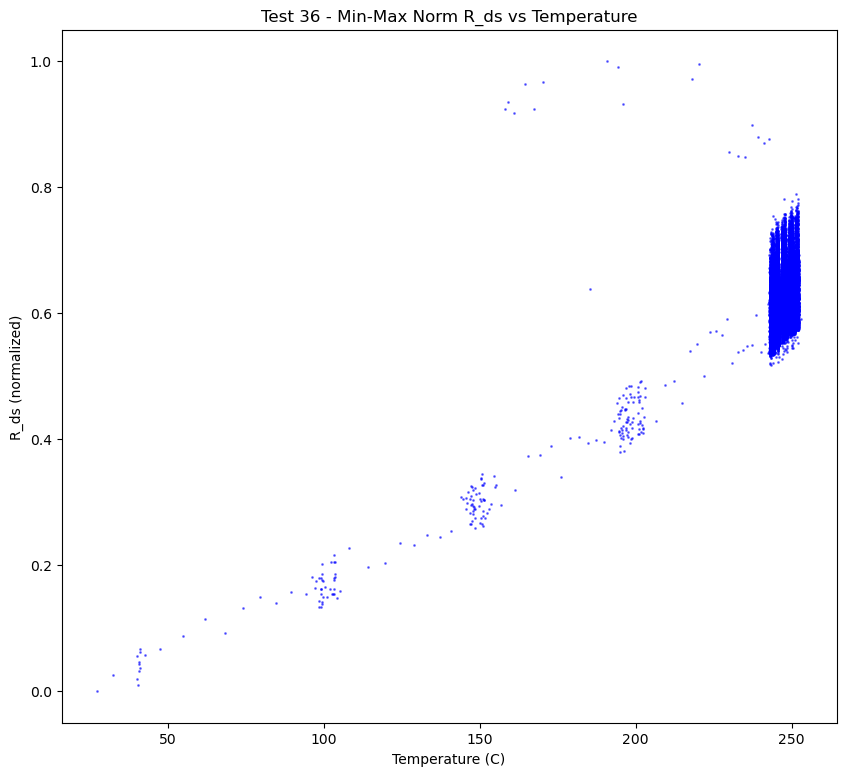

In [ ]:
#plot temperature vs r_ds
plt.figure(figsize=(10, 9))
plt.scatter( filtered_on_df["temperature"], filtered_on_df["norm2_R_ds"], s=1, c='blue', alpha=0.5)

plt.title(f'Test {experiment} - Min-Max Norm R_ds vs Temperature')
plt.xlabel('Temperature (C)')
plt.ylabel('R_ds (normalized)')



# Codigos por si acaso

Codigo que fui borrando, pero para no perderlo lo dejé en la celda

In [ ]:
for experiment in efective_experiments:
    # Cargar el archivo .mat
    mat_data = scipy.io.loadmat(f'MOSFET_Thermal_Overstress_Aging_v0/Test_{experiment}_run_1.mat', squeeze_me=True, struct_as_record=False)

    # Acceder al struct 'measurement'
    measurement = mat_data['measurement']

    # Acceder al campo 'steady'
    steady = measurement.steadyState 
    transient = measurement.transient
    print(transient[0].timeDomain.drainSourceVoltage )
    for measure in steady:
        if init:
            init_time = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            init = False
        fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
        time.append((fecha_dt-init_time)/60)

        # Leer corriente del drain 
        drain_current_n = measure.timeDomain.drainCurrent
        drain_current.append(drain_current_n)

        # Leer voltaje drain-source

        ds_voltage_n = measure.timeDomain.drainSourceVoltage
        ds_voltage.append(ds_voltage_n)


In [ ]:
# Antes de hacer la concatenacion de datframes

    # Acceder al campo 'steady'
    steady = measurement.steadyState 


    
    for measure in steady:
        if init:
            init_time = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
            init = False
        fecha_dt = datetime.strptime(measure.date, '%m/%d/%Y %H:%M:%S.%f').timestamp()
        time.append((fecha_dt-init_time)/60)

        # Leer corriente del drain 
        drain_current_n = measure.timeDomain.drainCurrent
        drain_current.append(drain_current_n)

        # Leer voltaje drain-source

        ds_voltage_n = measure.timeDomain.drainSourceVoltage
        ds_voltage.append(ds_voltage_n)
